In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import glob

# Define the path where your CSV files are stored
path = '../data/raw/*.csv'  

# Use glob to get all CSV file names in the directory
csv_files = glob.glob(path)

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
# combined_df = pd.concat(df_list, ignore_index=True)

In [3]:
df = pd.DataFrame(df_list[0])

# Check the data format
print(df.head(), df.shape)

              Datetime  PJMW_MW
0  2002-12-31 01:00:00   5077.0
1  2002-12-31 02:00:00   4939.0
2  2002-12-31 03:00:00   4885.0
3  2002-12-31 04:00:00   4857.0
4  2002-12-31 05:00:00   4930.0 (143206, 2)


In [4]:
df.rename(columns={'Datetime': 'ds', 'PJMW_MW': 'y'}, inplace=True)
df['ds']=pd.to_datetime(df.ds)

In [5]:
df.shape

(143206, 2)

In [7]:
class TrainUtils:
    def __init__(self, data):
        self.df = data  # Initialize the instance variable

    def process_data(self, n=10):
        # Some method to process the data
        return self.data * n

    def remove_outliers(self, column_name, method='IQR', z_threshold=3):
        """
        Remove outliers from time series data based on selected method: IQR or Z-score.
        
        Parameters:
        - df: pandas DataFrame, the time series data
        - column_name: str, the name of the column to remove outliers from
        - method: str, either 'IQR' or 'Z-score' method to detect outliers
        - z_threshold: int, the threshold for Z-score (default = 3)
        
        Returns:
        - df: pandas DataFrame, with outliers removed
        """
        if method == 'IQR':
            # Calculate IQR (Interquartile Range)
            Q1 = self.df[column_name].quantile(0.25)
            Q3 = self.df[column_name].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define lower and upper bounds for detecting outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Remove outliers based on IQR
            self.df = self.df[(self.df[column_name] >= lower_bound) & (self.df[column_name] <= upper_bound)]
            
        elif method == 'Z-score':
            # Calculate the Z-scores
            z_scores = (self.df[column_name] - self.df[column_name].mean()) / self.df[column_name].std()
            
            # Remove outliers based on Z-score threshold
            self.df = self.df[np.abs(z_scores) <= z_threshold]
        
        else:
            raise ValueError("Method must be either 'IQR' or 'Z-score'.")
        
        # return df_cleaned

    def data_split(self, split_param=0.2):
        return train_test_split(self.df, test_size=0.2, shuffle=False)  # No shuffle to maintain time order

In [8]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])


# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

20:43:37 - cmdstanpy - INFO - Chain [1] start processing
20:43:43 - cmdstanpy - INFO - Chain [1] done processing


NameError: name 'cross_validation' is not defined

In [9]:
df[pd.to_datetime(df.ds).dt.year >= 2014].shape

(40200, 2)

In [10]:
# Using the class
train_utils = TrainUtils(df[pd.to_datetime(df.ds).dt.year >= 2008])  # Initialize the object with data
train_utils.remove_outliers('y')
# Split the data into train and test sets using train_test_split
train_data, test_data = train_utils.data_split()

In [11]:
train_utils.df.shape, train_data.shape

((92261, 2), (73808, 2))

In [12]:
class TrainProphet:

    def __init__(self):
        pass
        
    def build_prophet_model(self, train_data):
        # Initialize and fit the Prophet model
        model = Prophet(seasonality_mode='multiplicative', changepoints=['2014-01-01'])
        
        # Add custom seasonality for day of the week
        model.add_seasonality(name='weekly', period=7, fourier_order=4)
        
        # Add custom seasonality for month of the year
        model.add_seasonality(name='monthly', period=365.25/12, fourier_order=6)
        
        # Add custom seasonality for month of the year
        model.add_seasonality(name='daily', period=1, fourier_order=10)

        # Add custom seasonality for month of the year
        model.add_seasonality(name='hourly', period=24, fourier_order=8)
        
        
        model.fit(train_data)
        return model

    def predict(self, model, periods):
        # Make future predictions (including the test period)
        future = model.make_future_dataframe(periods=10, freq='H')
        forecast = model.predict(future)
        return forecast

    def evaluate_model(self, forecast, test_data):
        # Merge forecasted values with actual test data for evaluation
        forecast_test = forecast.tail(len(test_data))  # Get forecast for the test period
        comparison = test_data[['ds', 'y']].merge(forecast_test[['ds', 'yhat']], on='ds')
        
        # Evaluate accuracy using scikit-learn error metrics
        mae = mean_absolute_error(comparison['y'], comparison['yhat'])
        mse = mean_squared_error(comparison['y'], comparison['yhat'])
        rmse = mean_squared_error(comparison['y'], comparison['yhat'], squared=False)
        mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat']) * 100
        
        # Print the results
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

        # Plot the actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(comparison['ds'], comparison['y'], label='Actual', color='blue')
        plt.plot(comparison['ds'], comparison['yhat'], label='Forecast', color='red', linestyle='--')
        plt.title('Actual vs Forecasted Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        return mae, mse, rmse, mape
        

20:58:41 - cmdstanpy - INFO - Chain [1] start processing
20:58:43 - cmdstanpy - INFO - Chain [1] done processing
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


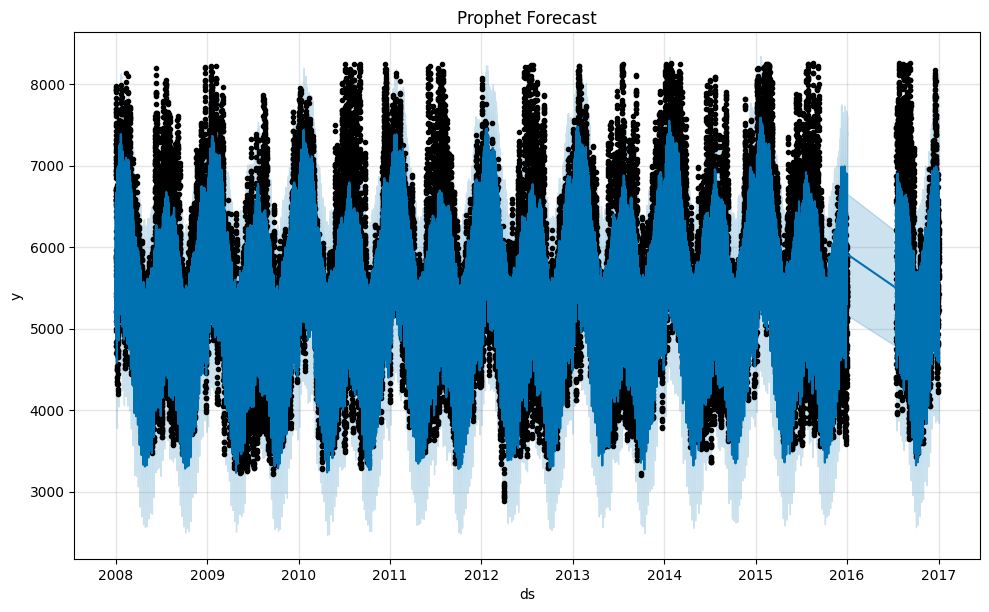

Mean Absolute Error (MAE): 236.08015094152879
Mean Squared Error (MSE): 74360.63887000455
Root Mean Squared Error (RMSE): 272.69147194220164
Mean Absolute Percentage Error (MAPE): 4.692318515234648%


/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


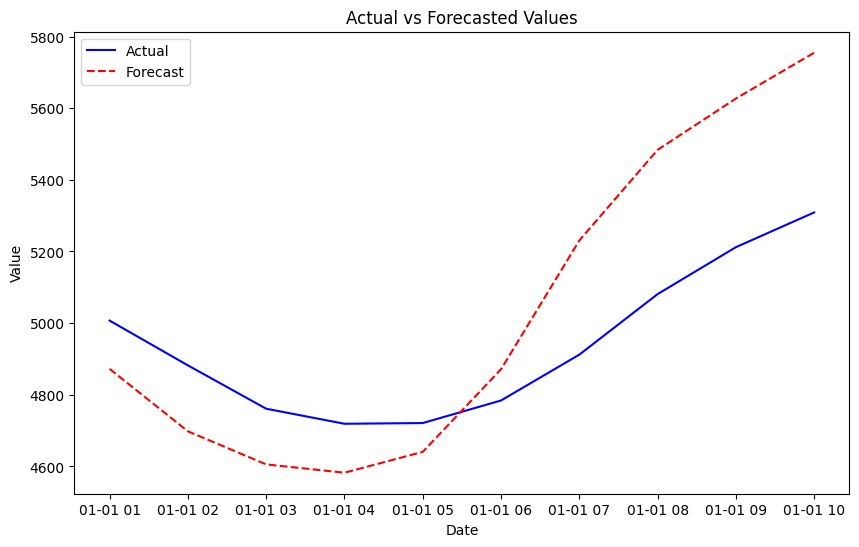

In [32]:
train = TrainProphet()
model = train.build_prophet_model(train_data)
forecast = train.predict(model, periods=20)

# Plot the forecast
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

mae, mse, rmse, mape = train.evaluate_model(forecast, test_data)

In [33]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,hourly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2008-01-01 00:00:00,5403.073152,4819.099014,6327.637329,5403.073152,5403.073152,-0.065797,-0.065797,-0.065797,-0.011263,...,0.038237,0.038237,0.038237,0.082376,0.082376,0.082376,0.0,0.0,0.0,5583.369187
1,2008-01-01 01:00:00,5403.076223,4504.232160,6024.192231,5403.076223,5403.076223,-0.118161,-0.118161,-0.118161,-0.011121,...,0.037708,0.037708,0.037708,0.082551,0.082551,0.082551,0.0,0.0,0.0,5299.434345
2,2008-01-01 02:00:00,5403.079295,4431.960327,5896.181457,5403.079295,5403.079295,-0.147796,-0.147796,-0.147796,-0.010954,...,0.037053,0.037053,0.037053,0.082727,0.082727,0.082727,0.0,0.0,0.0,5137.811453
3,2008-01-01 03:00:00,5403.082366,4312.017511,5755.921166,5403.082366,5403.082366,-0.163213,-0.163213,-0.163213,-0.010761,...,0.036308,0.036308,0.036308,0.082904,0.082904,0.082904,0.0,0.0,0.0,5052.695474
4,2008-01-01 04:00:00,5403.085437,4286.803183,5810.198320,5403.085437,5403.085437,-0.166707,-0.166707,-0.166707,-0.010546,...,0.035507,0.035507,0.035507,0.083083,0.083083,0.083083,0.0,0.0,0.0,5031.880285


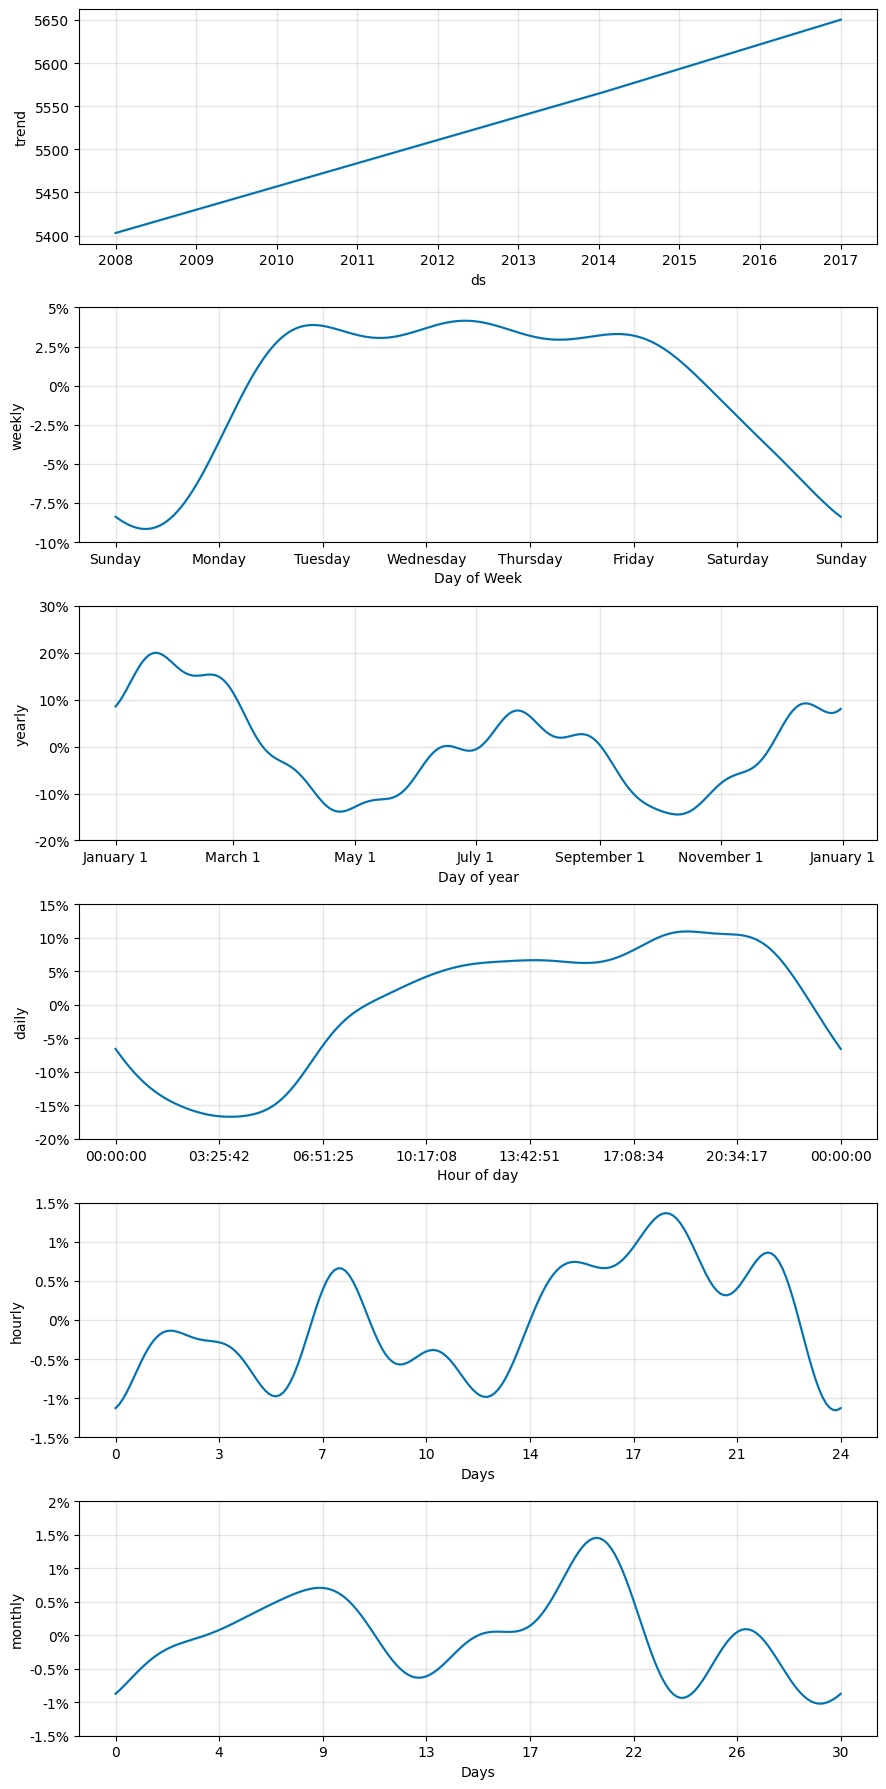

In [158]:
# Plot the forecast components (trend, seasonality)
model.plot_components(forecast)
plt.show()

/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will resu

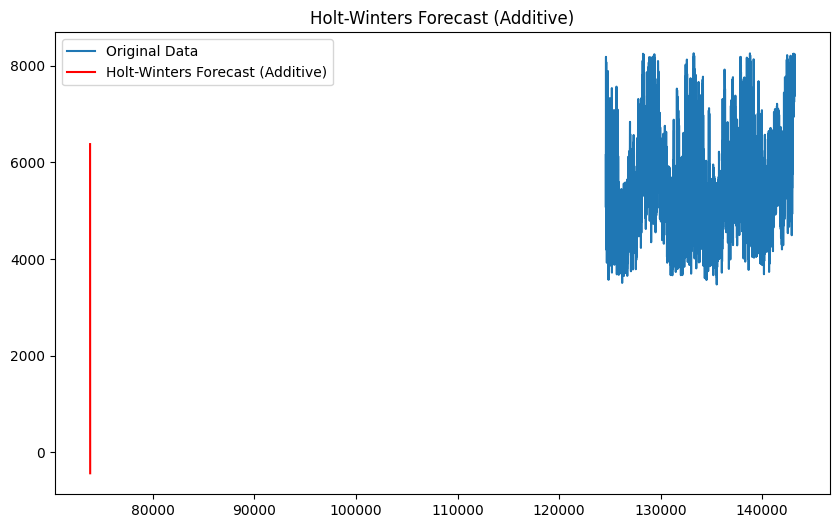

In [35]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Holt-Winters model (Additive) for seasonal data
model_additive = ExponentialSmoothing(
    train_data['y'], 
    trend='add',   # Use additive trend (you can also use 'mul' for multiplicative)
    seasonal='add',  # Use additive seasonality (use 'mul' for multiplicative seasonality)
    seasonal_periods=12*24  # Periods in a seasonal cycle, e.g., monthly seasonality if it's annual data (12 months)
)

# Fit the model
fitted_model_additive = model_additive.fit()

# Forecast for the next 12 periods (e.g., next 12 months or 12 time steps)
forecast_additive = fitted_model_additive.forecast(steps=12)

# Plot the original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['y'], label='Original Data')
plt.plot(forecast_additive.index, forecast_additive, label='Holt-Winters Forecast (Additive)', color='red')
plt.legend(loc='best')
plt.title('Holt-Winters Forecast (Additive)')
plt.show()

In [37]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,hourly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2008-01-01 00:00:00,5403.073152,4819.099014,6327.637329,5403.073152,5403.073152,-0.065797,-0.065797,-0.065797,-0.011263,...,0.038237,0.038237,0.038237,0.082376,0.082376,0.082376,0.0,0.0,0.0,5583.369187
1,2008-01-01 01:00:00,5403.076223,4504.232160,6024.192231,5403.076223,5403.076223,-0.118161,-0.118161,-0.118161,-0.011121,...,0.037708,0.037708,0.037708,0.082551,0.082551,0.082551,0.0,0.0,0.0,5299.434345
2,2008-01-01 02:00:00,5403.079295,4431.960327,5896.181457,5403.079295,5403.079295,-0.147796,-0.147796,-0.147796,-0.010954,...,0.037053,0.037053,0.037053,0.082727,0.082727,0.082727,0.0,0.0,0.0,5137.811453
3,2008-01-01 03:00:00,5403.082366,4312.017511,5755.921166,5403.082366,5403.082366,-0.163213,-0.163213,-0.163213,-0.010761,...,0.036308,0.036308,0.036308,0.082904,0.082904,0.082904,0.0,0.0,0.0,5052.695474
4,2008-01-01 04:00:00,5403.085437,4286.803183,5810.198320,5403.085437,5403.085437,-0.166707,-0.166707,-0.166707,-0.010546,...,0.035507,0.035507,0.035507,0.083083,0.083083,0.083083,0.0,0.0,0.0,5031.880285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73810,2017-01-01 06:00:00,5650.206825,4127.059533,5649.884087,5650.206825,5650.206825,-0.115384,-0.115384,-0.115384,-0.010053,...,-0.091457,-0.091457,-0.091457,0.086945,0.086945,0.086945,0.0,0.0,0.0,4871.234712
73811,2017-01-01 07:00:00,5650.210076,4479.203135,5965.364589,5650.210076,5650.210076,-0.052244,-0.052244,-0.052244,-0.009779,...,-0.091617,-0.091617,-0.091617,0.087153,0.087153,0.087153,0.0,0.0,0.0,5230.632966
73812,2017-01-01 08:00:00,5650.213328,4708.330134,6208.922916,5650.213328,5650.213328,-0.008339,-0.008339,-0.008339,-0.009488,...,-0.091395,-0.091395,-0.091395,0.087361,0.087361,0.087361,0.0,0.0,0.0,5483.619671
73813,2017-01-01 09:00:00,5650.216580,4856.932820,6415.313100,5650.216580,5650.216580,0.015743,0.015743,0.015743,-0.009184,...,-0.090774,-0.090774,-0.090774,0.087571,0.087571,0.087571,0.0,0.0,0.0,5626.956333


In [46]:
import statsmodels.api as sm

In [47]:
# set manually
CUTOFF_DATE = pd.to_datetime('2017-08-01')
TIME_DELTA = pd.DateOffset(years=8)

# splitting
train = df.loc[(df.index < CUTOFF_DATE) & (df.index >= CUTOFF_DATE-TIME_DELTA) ].copy()
test = df.loc[df.index >= CUTOFF_DATE].copy()

# exponential smoothing only takes into consideration patterns in the target variable
# so we discard the other features
exp_smooth_train, exp_smooth_test = train['y'], test['y']

# fit & predict
holt_winter = sm.tsa.ExponentialSmoothing(exp_smooth_train,
                                          seasonal_periods=24*365,
                                          seasonal='add').fit()
y_hat_holt_winter = holt_winter.forecast(len(exp_smooth_test))

/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/shalakathombare/path/to/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shalakathom